# Learning under Label Shift - GMM, 0-1 responses

In [1]:
import numpy as np
import mxnet as mx
from mxnet import nd, autograd, gluon

First let's set the centroids of our two classes and the marginal distributions during training and testing. 

In [2]:
means = np.array([[1, 1], [-1, -1]])
variance = 1
py_train = [.5, .5]
py_test = [.2, .8]

In [3]:
num_train = 90000
num_valid = 1000
num_test = 1000
num_features = 2
num_classes = 2

In [4]:
X_train = np.zeros((num_train, num_features))
X_valid = np.zeros((num_valid, num_features))
X_test = nd.zeros((num_test, num_features))

Y_train = np.random.choice(num_classes, num_train, p=py_train)
Y_valid = np.random.choice(num_classes, num_valid, p=py_train)
Y_test = np.random.choice(num_classes, num_test, p=py_test)

In [5]:
for i in range(num_train):
    X_train[i] = np.random.multivariate_normal(means[Y_train[i]], np.identity(num_features))
    
for i in range(num_valid):
    X_valid[i] = np.random.multivariate_normal(means[Y_valid[i]], np.identity(num_features))
    
for i in range(num_test):
    X_test[i] = np.random.multivariate_normal(means[Y_test[i]], np.identity(num_features))

In [6]:
import matplotlib.pyplot as plt

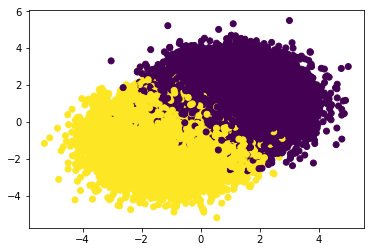

In [7]:
plt.scatter(X_train[:,0], X_train[:,1], c=Y_train)
plt.show()

## Now we'll train a simple logistic regression model to predict Y. 

In [8]:
data_ctx = mx.cpu()
model_ctx = mx.cpu()

net = gluon.nn.Dense(2)
net.collect_params().initialize(mx.init.Normal(sigma=1.), ctx=model_ctx)

ce_loss = gluon.loss.SoftmaxCrossEntropyLoss()

In [9]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.01})

In [10]:
batch_size = 1024

train_data = gluon.data.DataLoader(gluon.data.ArrayDataset(nd.array(X_train), nd.array(Y_train)),
                                      batch_size=batch_size, shuffle=True)

valid_data = gluon.data.DataLoader(gluon.data.ArrayDataset(nd.array(X_valid), nd.array(Y_valid)),
                                      batch_size=batch_size, shuffle=True)

test_data = gluon.data.DataLoader(gluon.data.ArrayDataset(nd.array(X_test), nd.array(Y_test)),
                                      batch_size=batch_size, shuffle=True)


In [11]:
epochs = 30
loss_sequence = []

for e in range(epochs):
    cumulative_loss = 0
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(model_ctx)
        label = label.as_in_context(model_ctx)
        with autograd.record():
            output = net(data)
            loss = ce_loss(output, label)
        loss.backward()
        trainer.step(batch_size)
        cumulative_loss += nd.sum(loss).asscalar()
    print("Epoch %s, loss: %s" % (e, cumulative_loss ))
    loss_sequence.append(cumulative_loss)

Epoch 0, loss: 51128.0938721
Epoch 1, loss: 30212.545105
Epoch 2, loss: 24620.7541046
Epoch 3, loss: 22134.5193329
Epoch 4, loss: 20752.161499
Epoch 5, loss: 19884.4256744
Epoch 6, loss: 19297.2088623
Epoch 7, loss: 18878.3023376
Epoch 8, loss: 18567.8334503
Epoch 9, loss: 18330.8624115
Epoch 10, loss: 18145.8636932
Epoch 11, loss: 17998.6114502
Epoch 12, loss: 17879.6465607
Epoch 13, loss: 17782.2668304
Epoch 14, loss: 17701.6795502
Epoch 15, loss: 17634.3476257
Epoch 16, loss: 17577.6451263
Epoch 17, loss: 17529.5833435
Epoch 18, loss: 17488.5479431
Epoch 19, loss: 17453.2896423
Epoch 20, loss: 17422.8839874
Epoch 21, loss: 17396.6068878
Epoch 22, loss: 17373.7073212
Epoch 23, loss: 17353.7559814
Epoch 24, loss: 17336.2953949
Epoch 25, loss: 17320.9209137
Epoch 26, loss: 17307.3816528
Epoch 27, loss: 17295.4575653
Epoch 28, loss: 17284.9480591
Epoch 29, loss: 17275.5889587


## Now let's go through the valdiation set and put together the response matrix

In [12]:
def softmax_to_onehot(preds):
    onehots = np.zeros_like(preds)
    argmaxes = np.argmax(preds, axis=1)
    onehots[np.arange(preds.shape[0]), argmaxes] = 1
    return onehots

In [13]:
response_matrix = nd.zeros((2,2))

In [14]:
valid_preds = nd.softmax(net(nd.array(X_valid)), axis=1)

In [15]:
valid_onehots = nd.array(softmax_to_onehot(valid_preds.asnumpy()))

In [16]:
nd.sum(valid_preds, axis=0)


[ 499.37445068  500.62554932]
<NDArray 2 @cpu(0)>

In [17]:
nd.sum(valid_onehots, axis=0)


[ 501.  499.]
<NDArray 2 @cpu(0)>

In [18]:
test_preds = nd.softmax(net(nd.array(X_test)), axis=1)

In [19]:
test_onehots =  nd.array(softmax_to_onehot(test_preds.asnumpy()))

In [20]:
# calculating the response using the onehots

test_response = nd.sum(test_onehots, axis=0) / num_test

In [21]:
test_response


[ 0.245  0.755]
<NDArray 2 @cpu(0)>

### Building the reponse matrix

Now we will build the response matric based on the classifier's output on the validation set. 
We will use the 0-1 one-hot responses, not the softmax outputs here.

In [22]:
YV = nd.array(Y_valid)
valid_counts = nd.zeros(num_classes)

for i in range(num_valid):
    response_matrix[:,int(Y_valid[i])] += valid_onehots[i] 
    valid_counts[int(Y_valid[i])] += 1

In [23]:
for j in range(num_classes):
    if valid_counts[j] > 0:
        response_matrix[:,j] /= valid_counts[j]

In [24]:
response_matrix


[[ 0.91566265  0.08964144]
 [ 0.08433735  0.91035855]]
<NDArray 2x2 @cpu(0)>

## Invert the response matrix and estimate the test set marginal P(Y)

In [25]:
R_inv = np.linalg.inv(response_matrix.asnumpy())

In [26]:
R_inv.dot(test_response.asnumpy())

array([ 0.18808059,  0.81191933], dtype=float32)

## Scratch

In [27]:
z = nd.array([[.1,.4,.5],
    [.4,.35,.25]])

In [28]:
def softmax_to_onehot(preds):
    onehots = np.zeros_like(preds)
    argmaxes = np.argmax(preds, axis=1)
    onehots[np.arange(2), argmaxes] = 1
    return onehots

In [29]:
z = np.array([[.1,.4,.5],
    [.4,.35,.25]])

softmax_to_onehot(z)

array([[ 0.,  0.,  1.],
       [ 1.,  0.,  0.]])

In [30]:
nd.one_hot(nd.argmax(nd.array([[.1,.4,.5],
    [.4,.35,.25]]), axis=1))

MXNetError: Required parameter depth of int is not presented, in operator one_hot(name="")